# Lab 2 - Linear Regression and Sparsity

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale, OneHotEncoder, PolynomialFeatures, StandardScaler
import statsmodels.formula.api as smf
%matplotlib inline

np.random.seed(0)

BASE_DIR = 'https://gitlab.com/machine-learning-course1/ml-practice-kt-2024-summer/-/raw/main'

In [ ]:
import itertools

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from tqdm import tnrange

## 1. Analyze Data

### 1.1. Load *Advertising* dataset
Datasets available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [ ]:
advertising = pd.read_csv(f'{BASE_DIR}/Data/Advertising.csv', usecols=[1,2,3,4])
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [ ]:
advertising.tail()

TV  Radio  Newspaper  Sales
195   38.2    3.7       13.8    7.6
196   94.2    4.9        8.1    9.7
197  177.0    9.3        6.4   12.8
198  283.6   42.0       66.2   25.5
199  232.1    8.6        8.7   13.4

## 2. Simple Linear Regression

### 2.1. Least Squares Fit / RSS

#### Figure 2.1. Least squares fit

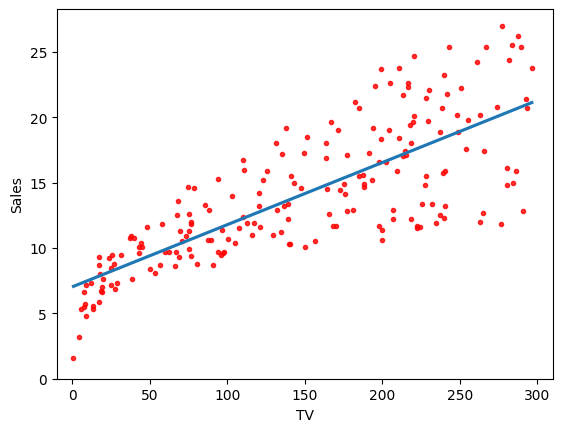

In [ ]:
fig, ax = plt.subplots()

sns.regplot(x=advertising['TV'], y=advertising['Sales'], order=1, ci=None, scatter_kws={'color':'r', 's':9}, ax=ax)

ax.set_xlim(-10,310)
ax.set_ylim(ymin=0)

fig.show()

#### Figure 2.2. Regression coefficients - RSS (Residual Sum of Squares)
Note that the text in the book describes the coefficients based on uncentered data, whereas the plot shows the model based on centered data. The latter is visually more appealing for explaining the concept of a minimum RSS. I think that, in order not to confuse the reader, the values on the axis of the B0 coefficients have been changed to correspond with the text. The axes on the plots below are unaltered.

In [ ]:
# Regression coefficients (Ordinary Least Squares)
regr = LinearRegression()

# Scale (center the data before scaling & scale the data to unit variance if true)
X = scale(advertising['TV'], with_mean=True, with_std=False).reshape(-1,1)
Y = advertising['Sales']

regr.fit(X, Y)
print(regr.intercept_)
print(regr.coef_)

14.0225
[0.04753664]


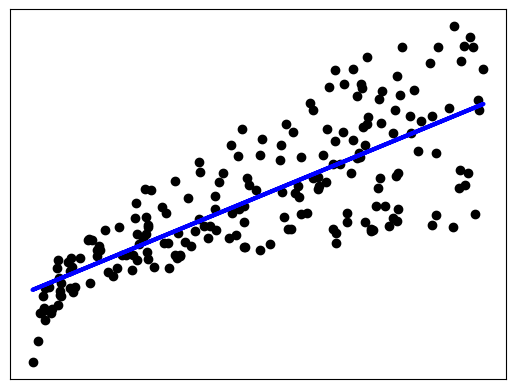

In [ ]:
Y_pred = regr.predict(X)

# Plot outputs
fig, ax = plt.subplots()

ax.scatter(X, Y,  color='black')
ax.plot(X, Y_pred, color='blue', linewidth=3)

ax.set_xticks([])
ax.set_yticks([])
fig.show()

#### Calculate RSS
Calculate the rss between y & y_pred

In [ ]:
np.sum((Y - Y_pred)**2)

2102.5305831313512

### 2.2. Exercise
Write your code in the cells below.

Follow the descriptions in Section 2.1 and plot a Linear Regression Graph & Calculate RSS

(X: Newspaper, y: Sales)

14.0225
[0.0546931]


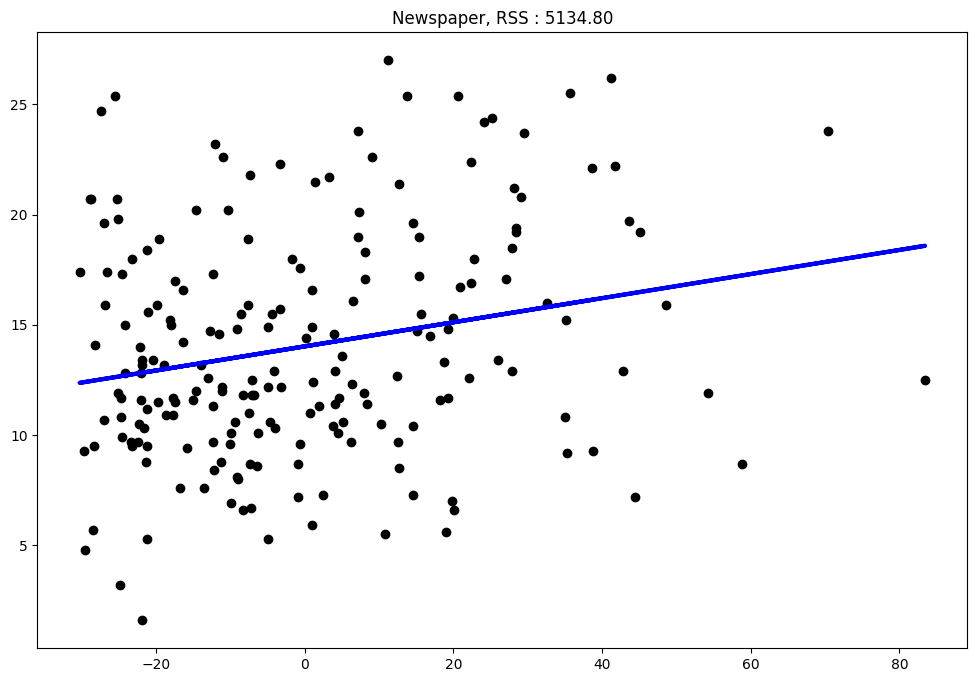

In [ ]:
regr2 = LinearRegression()
X2 = scale(advertising['Newspaper'], with_mean=True, with_std=False).reshape(-1, 1)

# TODO: Train the model


# TODO: Get the predicted values


# TODO: Plot the data


# TODO: Plot the prediction line

# TODO: Calculate RSS


### 2.3. Grid plot
Let's see the rss of B0, B1 near the value that we found

In [ ]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_ - 2, regr.intercept_ + 2, 50)
B1 = np.linspace(regr.coef_ - 0.02, regr.coef_ + 0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size, B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i, j), v in np.ndenumerate(Z):
    Z[i,j] = np.sum((Y - (xx[i,j] + X.reshape(-1) * yy[i,j])) ** 2)

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_ + regr.coef_ * X - Y.values.reshape(-1,1)) ** 2)
print(min_rss)

2102.5305831313512


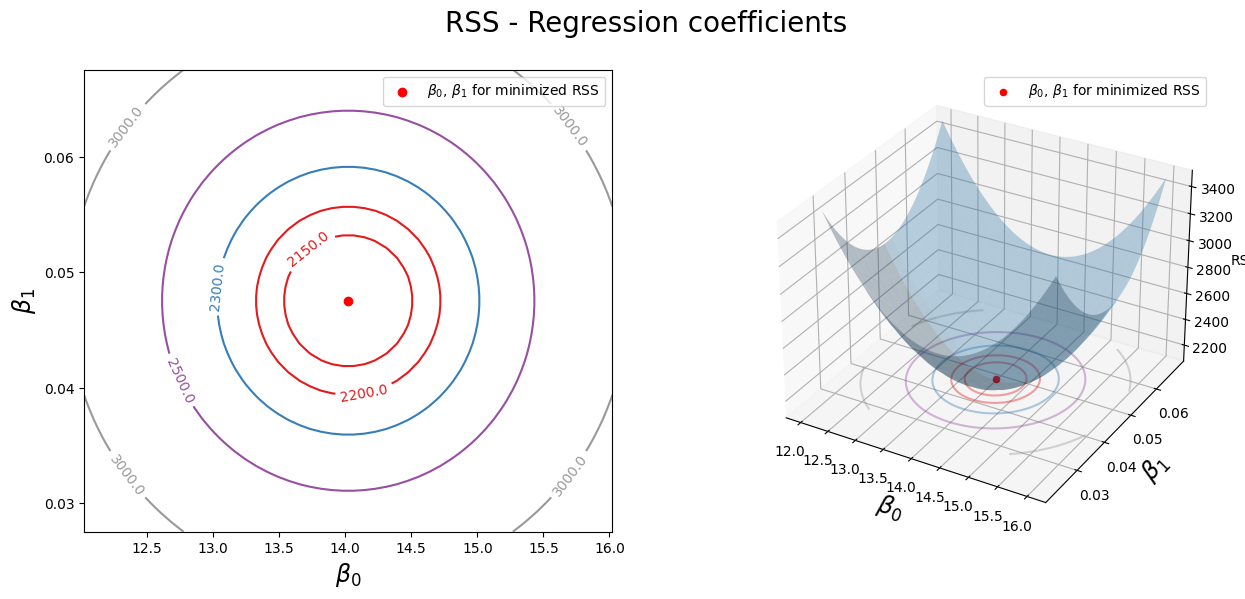

In [ ]:
fig = plt.figure(figsize=(15, 6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.get_cmap('Set1'), levels=[2150, 2200, 2300, 2500, 3000])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.get_cmap('Set1'),
            alpha=0.4, levels=[2150, 2200, 2300, 2500, 3000])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(), Z.max())
ax2.set_ylim(0.02, 0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

fig.show()

### 2.4. T value & Table - Statsmodels

smf.ols: alias for sm.OLS.from_formula </br>
formula + data -- patsy --> matrix used for fitting </br>
Basic stuff of formula:
* `~` separates into left-hand side and right-hand side
  * Left-hand side: dependent variables
  * Right-hand side: independent variables
* `+`: for multiple linear regression (will see in 3.1 of this notebook)
* `:` for interaction terms (will see in 4.3 of this notebook)

---

* Documentation for formula: https://patsy.readthedocs.io/en/latest/formulas.html
* Documentation for OLS: https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS
* Documentation for RegressionResults: https://www.statsmodels.org/devel/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults

In [ ]:
est = smf.ols('Sales ~ TV', advertising).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
est = smf.ols('Sales ~ Radio', advertising).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [ ]:
est = smf.ols('Sales ~ Newspaper', advertising).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

## 3. Multiple Linear Regression

#### Table 3.1 Statsmodels

In [ ]:
est = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Fri, 14 Jun 2024   Prob (F-statistic):           1.58e-96
Time:                        05:24:01   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Table 3.2 Statsmodels

In [ ]:
advertising.corr()

TV     Radio  Newspaper     Sales
TV         1.000000  0.054809   0.056648  0.782224
Radio      0.054809  1.000000   0.354104  0.576223
Newspaper  0.056648  0.354104   1.000000  0.228299
Sales      0.782224  0.576223   0.228299  1.000000

### 3.1. Compare t value of TV,Radio and Newpaper with fitness below
Plot the resulting regression line and a 95% confidence interval

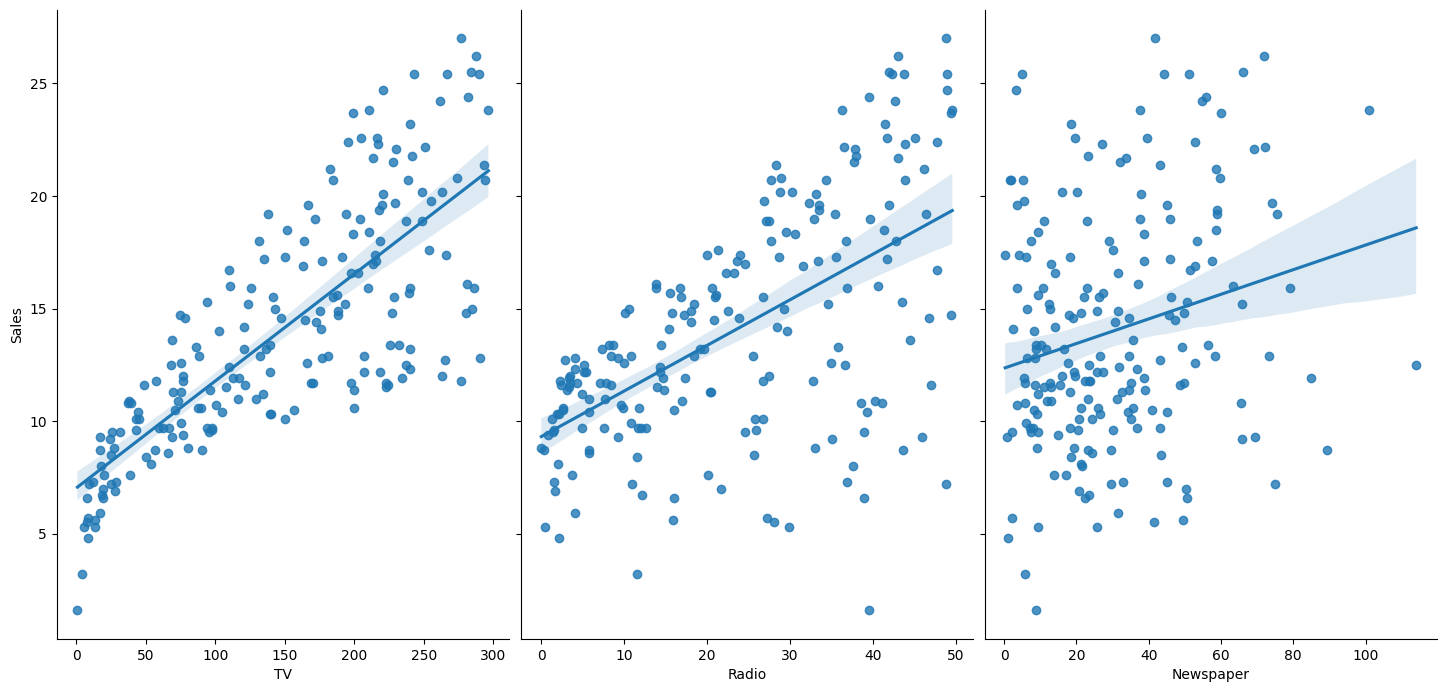

In [ ]:
sns.pairplot(advertising, x_vars=['TV', 'Radio', 'Newspaper'], y_vars='Sales', size=7, aspect=0.7, kind='reg')
# x_vars/y_vars: variables to use from data (to get a non-square plot)
# kind: {'scatter', 'kde', 'hist', 'reg'}
# aspect: Aspect * height gives the width (in inches)

In [ ]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Fri, 14 Jun 2024   Prob (F-statistic):           1.58e-96
Time:                        05:24:04   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3.2. Multiple Linear Regression

In [ ]:
regr = LinearRegression()

X = advertising[['Radio', 'TV']]
Y = advertising['Sales']

regr.fit(X, Y)
print(regr.coef_)
print(regr.intercept_)

[0.18799423 0.04575482]
2.9210999124051398


In [ ]:
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.
advertising[['Radio', 'TV']].describe()

Radio          TV
count  200.000000  200.000000
mean    23.264000  147.042500
std     14.846809   85.854236
min      0.000000    0.700000
25%      9.975000   74.375000
50%     22.900000  149.750000
75%     36.525000  218.825000
max     49.600000  296.400000

### Figure 3.1 Plot 3D data

In [ ]:
# Create a coordinate grid
Radio = np.arange(0, 50)
TV = np.arange(0, 300)

B1, B2 = np.meshgrid(Radio, TV, indexing='ij')
Z = np.zeros((Radio.size, TV.size))

for (i,j),v in np.ndenumerate(Z):
    Z[i,j] = (regr.intercept_ + B1[i,j] * regr.coef_[0] + B2[i,j] * regr.coef_[1])

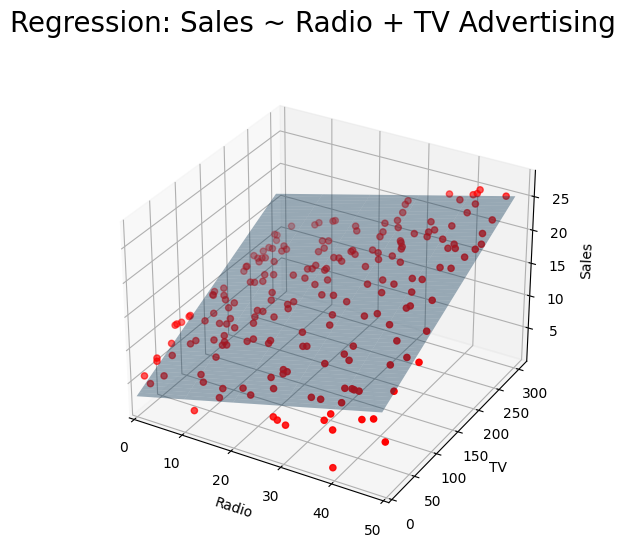

In [ ]:
# Create plot
fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': '3d'})
fig.suptitle('Regression: Sales ~ Radio + TV Advertising', fontsize=20)

ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(advertising['Radio'], advertising['TV'], advertising['Sales'], c='r')

ax.set_xlabel('Radio')
ax.set_xlim(0, 50)
ax.set_ylabel('TV')
ax.set_ylim(ymin=0)
ax.set_zlabel('Sales')
fig.show()

In [ ]:
regr = LinearRegression()

X = advertising[['Radio', 'TV', 'Newspaper']]
Y = advertising['Sales']

regr.fit(X, Y)
print(regr.coef_)
print(regr.intercept_)

advertising[['Radio', 'TV', 'Newspaper']].describe()

[ 0.18853002  0.04576465 -0.00103749]
2.9388893694594067


Radio          TV   Newspaper
count  200.000000  200.000000  200.000000
mean    23.264000  147.042500   30.554000
std     14.846809   85.854236   21.778621
min      0.000000    0.700000    0.300000
25%      9.975000   74.375000   12.750000
50%     22.900000  149.750000   25.750000
75%     36.525000  218.825000   45.100000
max     49.600000  296.400000  114.000000

### 3.3. Exercise
Follow below descriptions to analyze Credit data (X : Age, Income Y: Balance)
Load f'{BASE_DIR}/Data/Credit.csv' data with pd.read_csv() methodFit multiple linear regressionDescribe data to set up the grid valuesCreate plot using plt.axes(projection='3d') (Figure 3.1)

In [ ]:
# Load f'{BASE_DIR}/Data/Credit.csv' data with pd.read_csv() method
credit = pd.read_csv(f'{BASE_DIR}/Data/Credit.csv', usecols=list(range(1,12)))


In [ ]:
# Fit multiple linear regression (X: Age, Income Y: Balance)


[-2.18506745  6.23587908]
359.67274306126217


In [ ]:
# Describe data to set up the grid values
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.


Age      Income
count  400.000000  400.000000
mean    55.667500   45.218885
std     17.249807   35.244273
min     23.000000   10.354000
25%     41.750000   21.007250
50%     56.000000   33.115500
75%     70.000000   57.470750
max     98.000000  186.634000

In [ ]:
# Create plot using plt.axes(projection='3d')

# Create a coordinate grid


# Create plot


## 4. Other Considerations in the Regression Model

### 4.1. Qantative variables & Interaction term

#### Load Credit Dataset

In [ ]:
credit = pd.read_csv(f'{BASE_DIR}/Data/Credit.csv', usecols=list(range(1, 12)))
credit['Student2'] = credit['Student'].map({'No':0, 'Yes':1})
credit.head(3)

Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   14.891   3606     283      2   34         11    Male      No     Yes   
1  106.025   6645     483      3   82         15  Female     Yes     Yes   
2  104.593   7075     514      4   71         11    Male      No      No   

   Ethnicity  Balance  Student2  
0  Caucasian      333         0  
1      Asian      903         1  
2      Asian      580         0

#### Figure 4.1 Pair plot

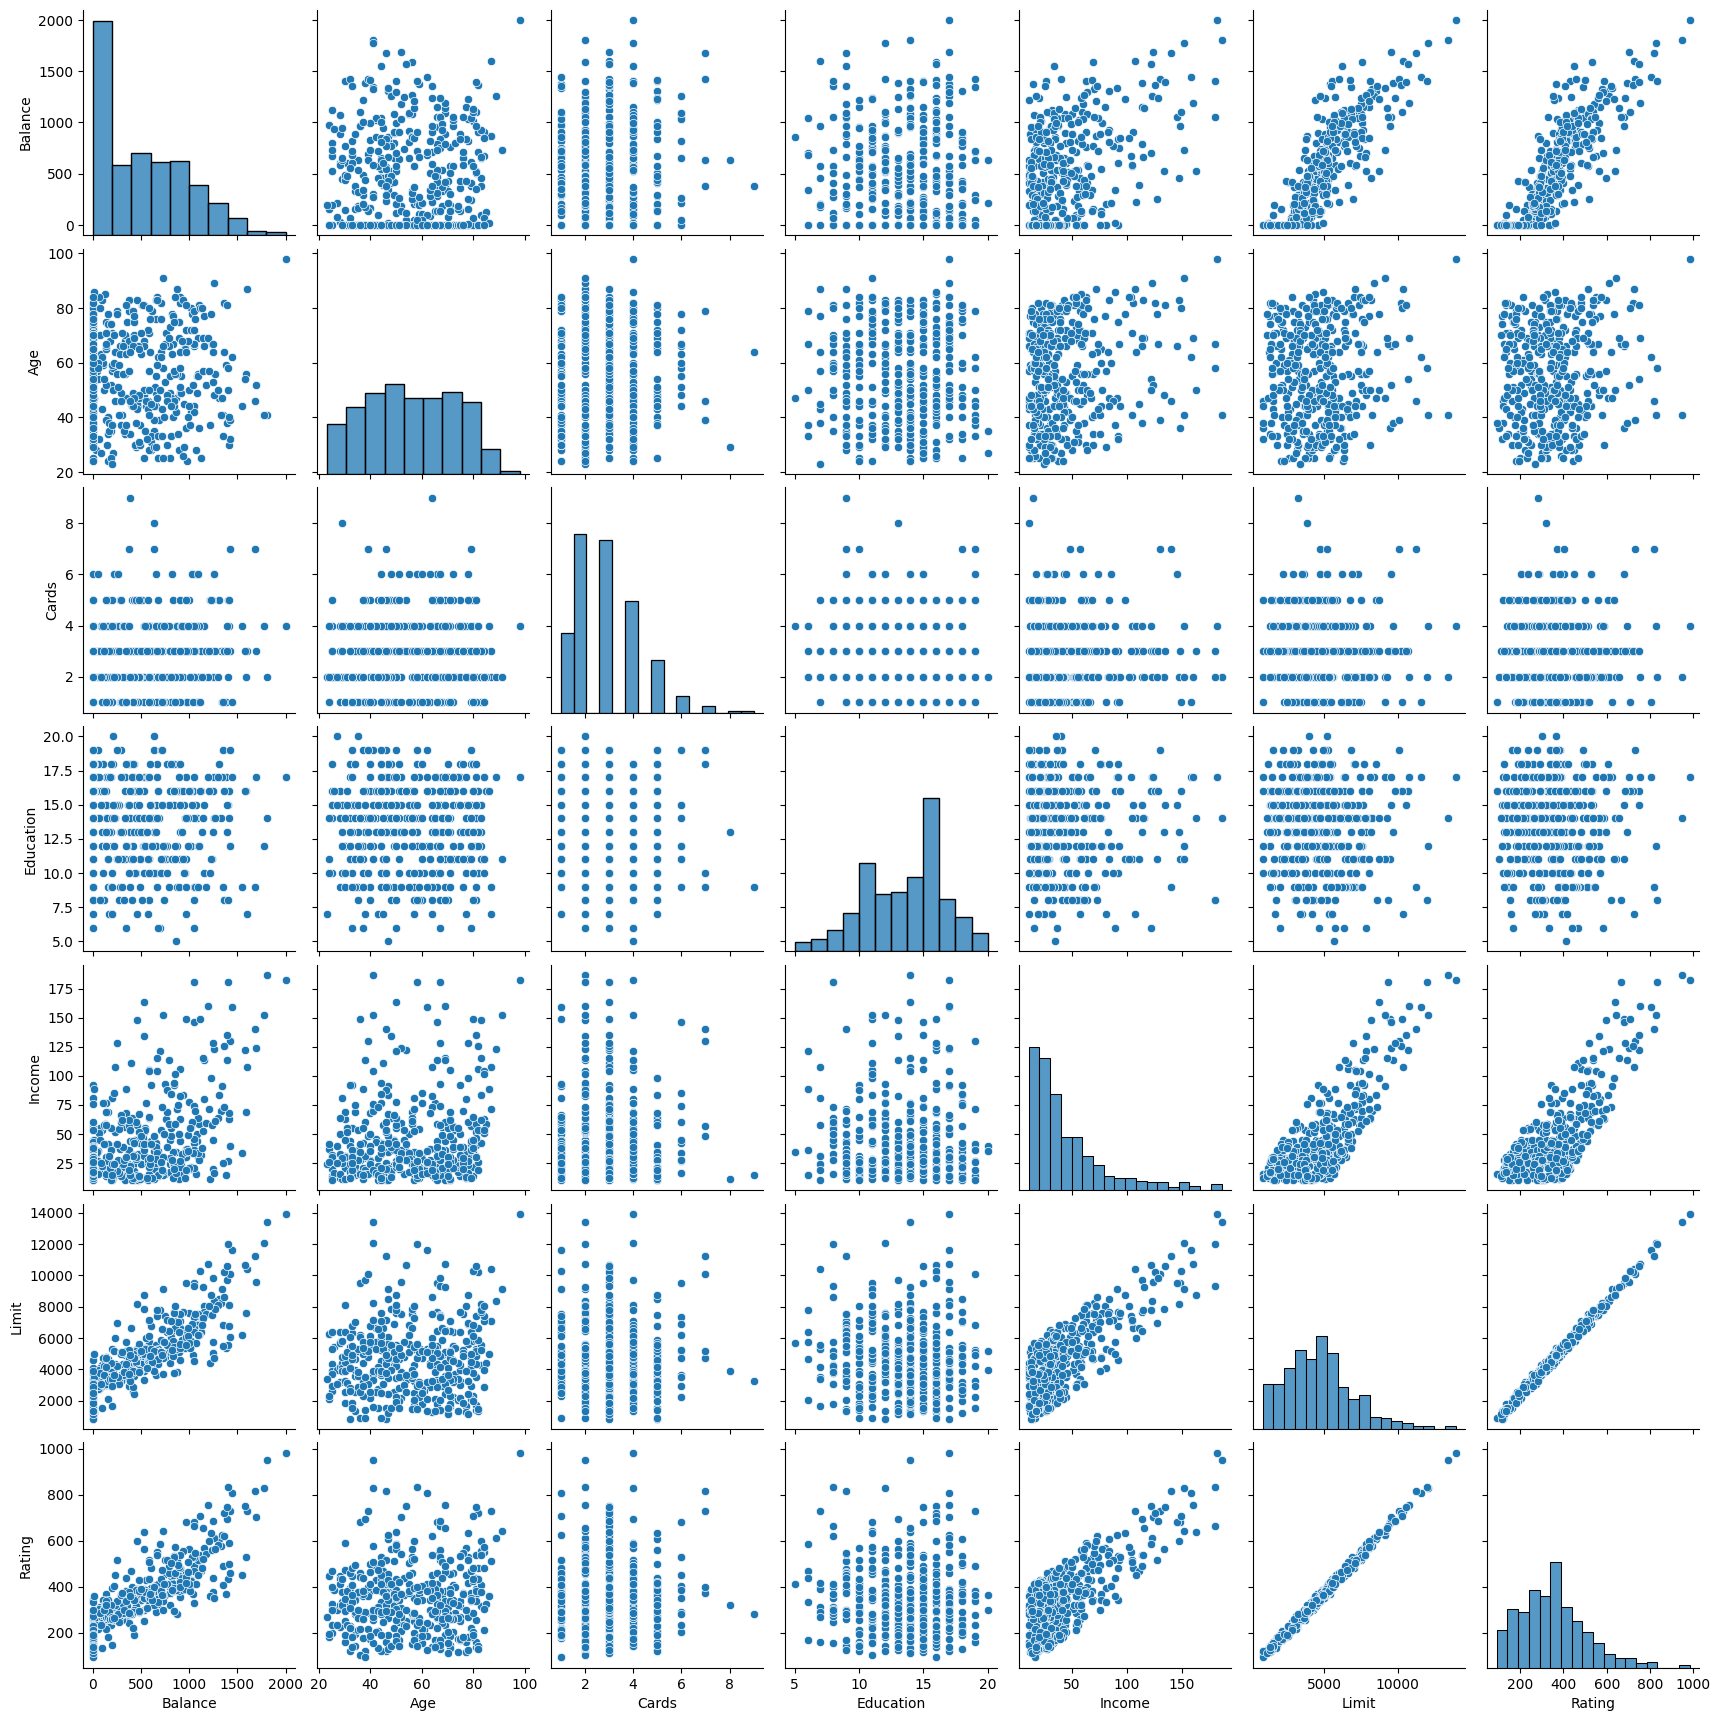

In [ ]:
sns.pairplot(credit[['Balance', 'Age', 'Cards', 'Education', 'Income', 'Limit', 'Rating']])

#### Table 4.1
Least squares coefficient estimates associated with the regression of
balance onto gender in the Credit data set.
Gender is encoded as a dummy variable.

In [ ]:
print(credit['Gender'].unique())
est = smf.ols('Balance ~ Gender', credit).fit()
est.summary().tables[1]

[' Male' 'Female']


<class 'statsmodels.iolib.table.SimpleTable'>

#### Table 4.2
Least squares coefficient estimates associated with the regression
of balance onto ethnicity in the Credit data set.
Ethnicity is encoded via two dummy variables

In [ ]:
print(credit['Ethnicity'].unique())
est = smf.ols('Balance ~ Ethnicity', credit).fit()
est.summary().tables[1]

['Caucasian' 'Asian' 'African American']


<class 'statsmodels.iolib.table.SimpleTable'>

### 4.2. OneHotEncoding - Quantative variables using sklearn

In [ ]:
credit.head(3)

Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   14.891   3606     283      2   34         11    Male      No     Yes   
1  106.025   6645     483      3   82         15  Female     Yes     Yes   
2  104.593   7075     514      4   71         11    Male      No      No   

   Ethnicity  Balance  Student2  
0  Caucasian      333         0  
1      Asian      903         1  
2      Asian      580         0

In [ ]:
categorical_cols = ['Ethnicity', 'Gender', 'Student', 'Married']
X_categorical = credit[categorical_cols]
X_numerical = credit.drop(categorical_cols, axis=1).astype('float64')
X_categorical.head()

Ethnicity  Gender Student Married
0  Caucasian    Male      No     Yes
1      Asian  Female     Yes     Yes
2      Asian    Male      No      No
3      Asian  Female      No      No
4  Caucasian    Male      No     Yes

In [ ]:
enc = OneHotEncoder()
enc.fit(X_categorical)
print(enc.transform(X_categorical).toarray()[10:15])

[[0. 0. 1. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 1.]
 [0. 0. 1. 1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 1. 1. 0. 1. 0.]]


In [ ]:
X_concat = np.concatenate([X_numerical, enc.transform(X_categorical).toarray()], 1)
Y = credit['Balance']

print(X.shape, enc.transform(X_categorical).shape, X_concat.shape)

(400, 2) (400, 9) (400, 17)


#### Table 4.3 Interaction Variables
For the Advertising data, least squares coefficient estimates associated with the regression of sales onto TV and radio, with an interaction term

In [ ]:
est = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

#### Figure 4.2 Interaction between qualitative and quantative variables

In [ ]:
est1 = smf.ols('Balance ~ Income + Student2', credit).fit()
regr1 = est1.params
est2 = smf.ols('Balance ~ Income + Income*Student2', credit).fit()
regr2 = est2.params

print('Regression 1 - without interaction term')
print(regr1)
print('\nRegression 2 - with interaction term')
print(regr2)

Regression 1 - without interaction term
Intercept    211.142964
Income         5.984336
Student2     382.670539
dtype: float64

Regression 2 - with interaction term
Intercept          200.623153
Income               6.218169
Student2           476.675843
Income:Student2     -1.999151
dtype: float64


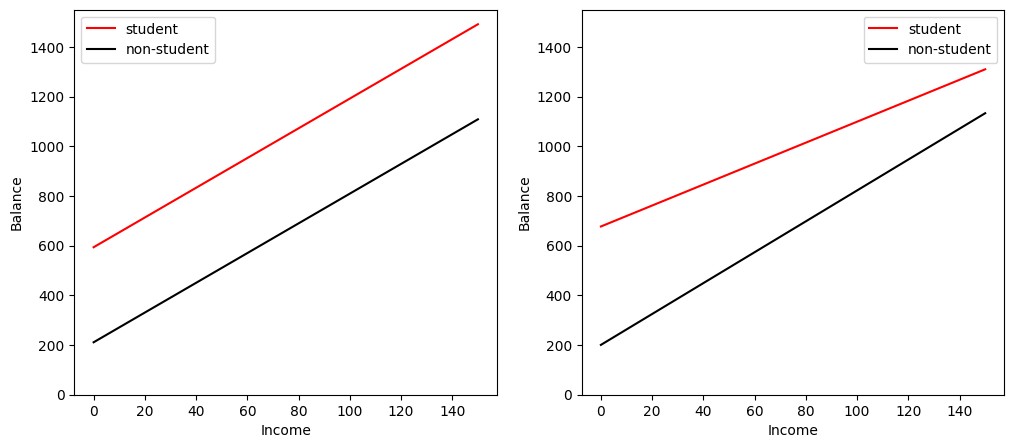

In [ ]:
# Income (x-axis)
income = np.linspace(0, 150)

# Balance without interaction term (y-axis)
student1 = np.linspace(regr1['Intercept'] + regr1['Student2'],
                       regr1['Intercept'] + regr1['Student2'] + 150 * regr1['Income'])
non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept'] + 150 * regr1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept'] + regr2['Student2'],
                       regr2['Intercept'] + regr2['Student2']+
                       150 * (regr2['Income'] + regr2['Income:Student2']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept'] + 150 * regr2['Income'])

# Create plot
fig, axes = plt.subplots(1,2, figsize=(12,5))
ax1, ax2 = axes
ax1.plot(income, student1, 'r', label='student')
ax1.plot(income, non_student1, 'k', label='non-student')
ax2.plot(income, student2, 'r', label='student')
ax2.plot(income, non_student2, 'k', label='non-student')

for ax in axes:
    ax.legend()
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim((0, 1550))
fig.show()

### 4.3. Non-linear relationships

#### Load Automobile Dataset

In [ ]:
auto = pd.read_csv(f'{BASE_DIR}/Data/Auto.csv', na_values='?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


In [ ]:
auto.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0    3504          12.0    70   
1  15.0          8         350.0       165.0    3693          11.5    70   
2  18.0          8         318.0       150.0    3436          11.0    70   
3  16.0          8         304.0       150.0    3433          12.0    70   
4  17.0          8         302.0       140.0    3449          10.5    70   

   origin                       name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino

#### Figure 3.4 Non-linear relationships

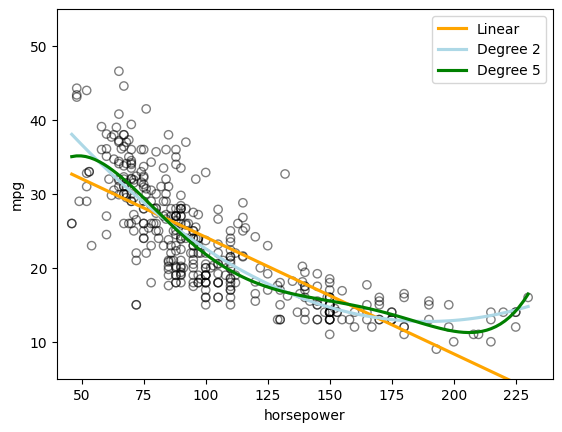

In [ ]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
fig, ax = plt.subplots()

ax.scatter(auto.horsepower, auto.mpg, facecolors='None', edgecolors='k', alpha=.5)
sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Linear', scatter=False, color='orange', ax=ax)
sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Degree 2', order=2, scatter=False, color='lightblue', ax=ax)
sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Degree 5', order=5, scatter=False, color='g', ax=ax)

ax.legend()
ax.set_ylim(5,55)
ax.set_xlim(40,240)
fig.show()

#### Figure 3.5

In [ ]:
auto['horsepower2'] = auto['horsepower'] ** 2
auto['h:c'] = auto['horsepower'] * auto['cylinders']

# Linear fit
regr = LinearRegression()
X = auto[['horsepower']]
Y = auto['mpg']
regr.fit(X, Y)

auto['pred1'] = regr.predict(X)
auto['residual1'] = auto['mpg'] - auto['pred1']

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']].values
regr.fit(X2, Y)

auto['pred2'] = regr.predict(X2)
auto['residual2'] = auto['mpg'] - auto['pred2']

In [ ]:
auto.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0       130.0    3504          12.0    70   
1  15.0          8         350.0       165.0    3693          11.5    70   
2  18.0          8         318.0       150.0    3436          11.0    70   
3  16.0          8         304.0       150.0    3433          12.0    70   
4  17.0          8         302.0       140.0    3449          10.5    70   

   origin                       name  horsepower2     h:c      pred1  \
0       1  chevrolet chevelle malibu      16900.0  1040.0  19.416046   
1       1          buick skylark 320      27225.0  1320.0  13.891480   
2       1         plymouth satellite      22500.0  1200.0  16.259151   
3       1              amc rebel sst      22500.0  1200.0  16.259151   
4       1                ford torino      19600.0  1120.0  17.837598   

   residual1      pred2  residual2  
0  -1.416046  17.091508   0.908492  
1   1.108520  13.480156   1.519844  
2   1.740849  14.658717   3.341283  
3  -0.259151  14.658717   1.341283  
4  -0.837598  15.752059   1.247941

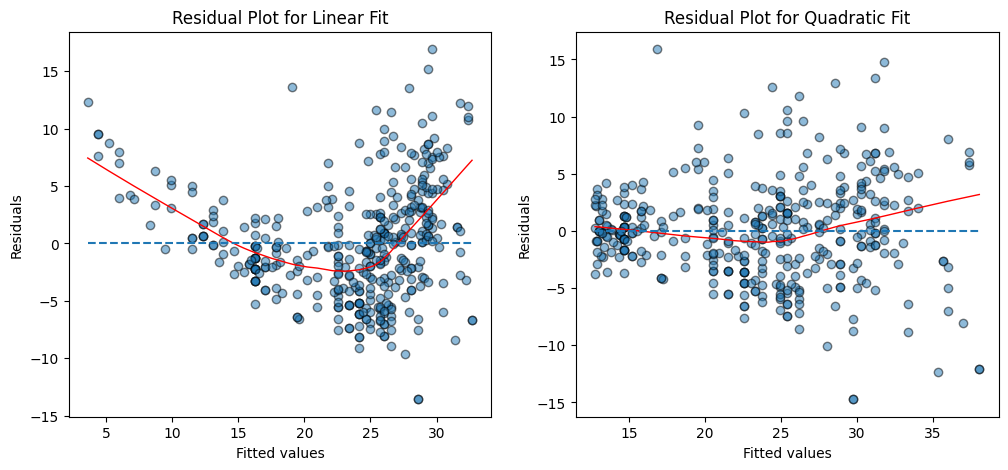

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
ax1, ax2 = axes

line_kws = {
    'color': 'r',
    'lw': 1,
}
scatter_kws = {
    'facecolors': None,
    'edgecolors': 'k',
    'alpha':0.5,
}

# Left plot
sns.regplot(x=auto['pred1'], y=auto['residual1'], lowess=True,
            line_kws=line_kws, scatter_kws=scatter_kws, ax=ax1)
ax1.hlines(0, xmin=ax1.xaxis.get_data_interval()[0], xmax=ax1.xaxis.get_data_interval()[1], linestyles='--')
ax1.set_title('Residual Plot for Linear Fit')

# Right plot
sns.regplot(x=auto['pred2'], y=auto['residual2'], lowess=True,
            line_kws=line_kws, scatter_kws=scatter_kws, ax=ax2)
ax2.hlines(0, xmin=ax2.xaxis.get_data_interval()[0], xmax=ax2.xaxis.get_data_interval()[1], linestyles='--')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
fig.show()

### 4.4. PolynomialFeatures - Generate interaction term / polynomial features using sklearn

In [ ]:
X = auto[['weight', 'acceleration']]
X.head()

weight  acceleration
0    3504          12.0
1    3693          11.5
2    3436          11.0
3    3433          12.0
4    3449          10.5

In [ ]:
poly = PolynomialFeatures(2)
print(poly.fit_transform(X)[:3])  # 1, horsepower, weight, horsepower^2, horsepower*weight, weight^2

[[1.0000000e+00 3.5040000e+03 1.2000000e+01 1.2278016e+07 4.2048000e+04
  1.4400000e+02]
 [1.0000000e+00 3.6930000e+03 1.1500000e+01 1.3638249e+07 4.2469500e+04
  1.3225000e+02]
 [1.0000000e+00 3.4360000e+03 1.1000000e+01 1.1806096e+07 3.7796000e+04
  1.2100000e+02]]


In [ ]:
poly_interaction = PolynomialFeatures(interaction_only=True)
poly_interaction.fit_transform(X)
print(poly_interaction.fit_transform(X)[:3])  # 1, horsepower, weight, horsepower*weight

[[1.00000e+00 3.50400e+03 1.20000e+01 4.20480e+04]
 [1.00000e+00 3.69300e+03 1.15000e+01 4.24695e+04]
 [1.00000e+00 3.43600e+03 1.10000e+01 3.77960e+04]]


### 4.5. Exercise

Follow below descriptions to analyze Hitters data (X: Hits, HmRun, League Y: Salary)

1. Load f'{BASE_DIR}/Data/Hitters.csv' data with pd.read_csv() method
2. Use PolynomialFeatures to generate interaction term / polynomical features for plotting
3. Use OneHotEncoder to add categorical feature (origin)
4. Plot residuals (Follow steps in Figure 3.5) with default features / interaction terms / second order polynomial features / high-order polynomial features

In [ ]:
# TODO: Load f'{BASE_DIR}/Data/Hitters.csv' data with pd.read_csv() method
hitters = pd.read_csv(f'{BASE_DIR}/Data/Hitters.csv', index_col=0).dropna()
hitters.index.name = 'Player'
hitters.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
Player                                                                          
-Alan Ashby          315    81      7    24   38     39     14    3449    835   
-Alvin Davis         479   130     18    66   72     76      3    1624    457   
-Andre Dawson        496   141     20    65   78     37     11    5628   1575   
-Andres Galarraga    321    87     10    39   42     30      2     396    101   
-Alfredo Griffin     594   169      4    74   51     35     11    4408   1133   

                   CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  \
Player                                                                    
-Alan Ashby            69    321   414     375      N        W      632   
-Alvin Davis           63    224   266     263      A        W      880   
-Andre Dawson         225    828   838     354      N        E      200   
-Andres Galarraga      12     48    46      33      N        E      805   
-Alfredo Griffin       19    501   336     194      A        W      282   

                   Assists  Errors  Salary NewLeague  
Player                                                
-Alan Ashby             43      10   475.0         N  
-Alvin Davis            82      14   480.0         A  
-Andre Dawson           11       3   500.0         N  
-Andres Galarraga       40       4    91.5         N  
-Alfredo Griffin       421      25   750.0         A

In [ ]:
# TODO: Use OneHotEncoder to add categorical feature
categorical_cols = ['League']

X2 = hitters[categorical_cols]



[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [ ]:
# Use PolynomialFeatures to generate interaction term / polynomical features for plotting
X = hitters[['Hits', 'HmRun']]
print('X')
print(X[:5])
print()

poly = PolynomialFeatures(2)
print('PolynomialFeatures(2)')
print(poly.fit_transform(X)[:5])  # 1, hits, hmrun, hits^2, hits * hmrun, hmrun^2
print()

poly_interaction = PolynomialFeatures(2, interaction_only=True)
print('PolynomialFeatures(2, interaction_only=True)')
print(poly_interaction.fit_transform(X)[:5])  # 1, hits, hmrun, hits * hmrun
print()

poly_high = PolynomialFeatures(3)
print('PolynomialFeatures(3)')
print(poly_high.fit_transform(X)[:5])  # 1, hits, hmrun, hits * hmrun
print()

X
                   Hits  HmRun
Player                        
-Alan Ashby          81      7
-Alvin Davis        130     18
-Andre Dawson       141     20
-Andres Galarraga    87     10
-Alfredo Griffin    169      4

PolynomialFeatures(2)
[[1.0000e+00 8.1000e+01 7.0000e+00 6.5610e+03 5.6700e+02 4.9000e+01]
 [1.0000e+00 1.3000e+02 1.8000e+01 1.6900e+04 2.3400e+03 3.2400e+02]
 [1.0000e+00 1.4100e+02 2.0000e+01 1.9881e+04 2.8200e+03 4.0000e+02]
 [1.0000e+00 8.7000e+01 1.0000e+01 7.5690e+03 8.7000e+02 1.0000e+02]
 [1.0000e+00 1.6900e+02 4.0000e+00 2.8561e+04 6.7600e+02 1.6000e+01]]

PolynomialFeatures(2, interaction_only=True)
[[1.00e+00 8.10e+01 7.00e+00 5.67e+02]
 [1.00e+00 1.30e+02 1.80e+01 2.34e+03]
 [1.00e+00 1.41e+02 2.00e+01 2.82e+03]
 [1.00e+00 8.70e+01 1.00e+01 8.70e+02]
 [1.00e+00 1.69e+02 4.00e+00 6.76e+02]]

PolynomialFeatures(3)
[[1.000000e+00 8.100000e+01 7.000000e+00 6.561000e+03 5.670000e+02
  4.900000e+01 5.314410e+05 4.592700e+04 3.969000e+03 3.430000e+02]
 [1.000000e+

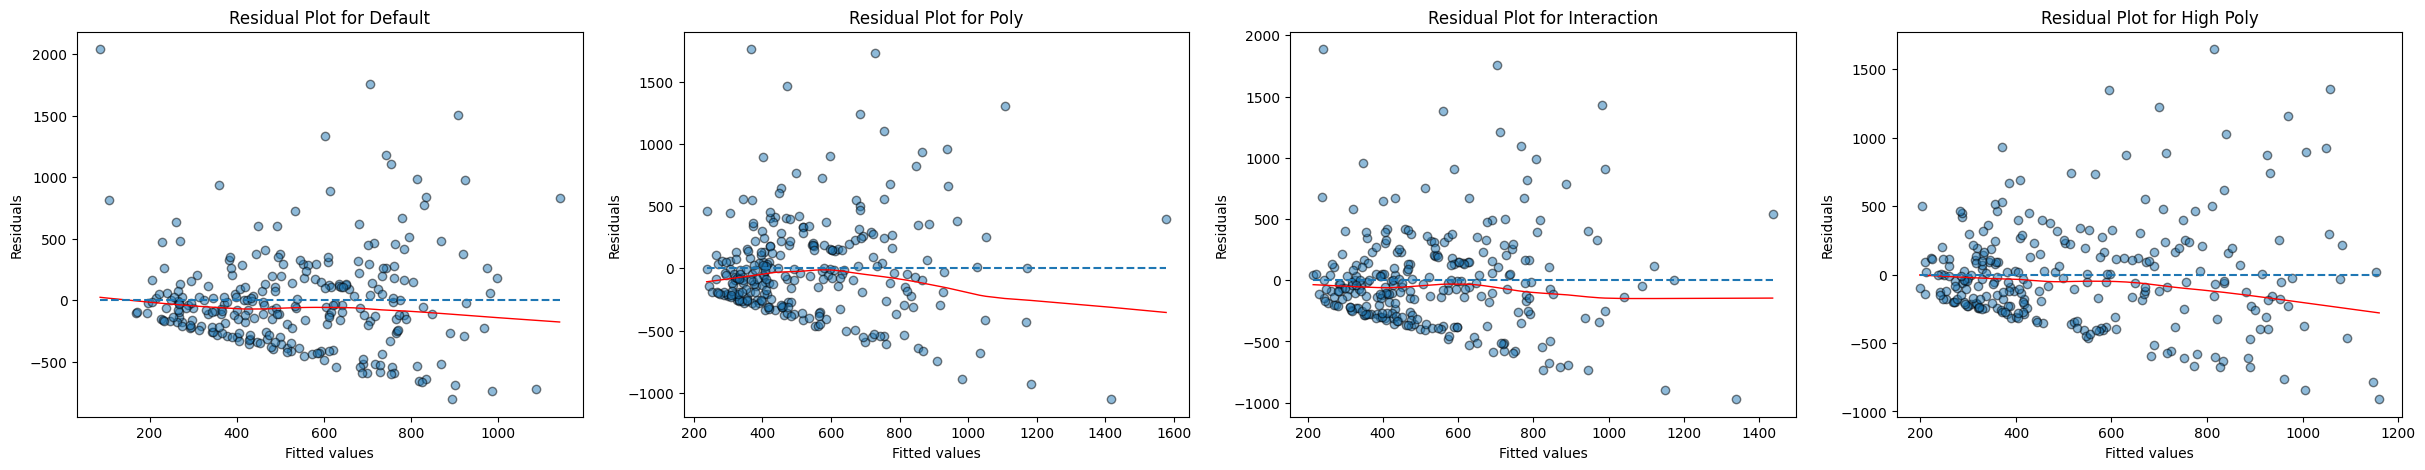

In [ ]:
Xs = {
    'Default':     np.hstack([X, enc.transform(X2).toarray()]),
    'Poly':        np.hstack([poly.fit_transform(X), enc.transform(X2).toarray()]),
    'Interaction': np.hstack([poly_interaction.fit_transform(X), enc.transform(X2).toarray()]),
    'High Poly':   np.hstack([poly_high.fit_transform(X), enc.transform(X2).toarray()]),
}
Y = hitters['Salary']

# Fit LinearRegression and plot residuals (Follow steps in Figure 3.5)
# with default features / interaction terms / second order polynomial features / high-order polynomial features
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
for ax, (name, X) in zip(axes, Xs.items()):
  # Fit LinearRegression


  # Left plot


for ax in axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
fig.show()

## 5. Model Selection Methods

### 5.1. Load dataset
The credit dataset is a use case for linear regression where some predictors are qualitative.

In [ ]:
credit = pd.read_csv(f'{BASE_DIR}/Data/Credit.csv')
credit = credit.drop(columns=['Unnamed: 0'])
credit.head(3)

Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   14.891   3606     283      2   34         11    Male      No     Yes   
1  106.025   6645     483      3   82         15  Female     Yes     Yes   
2  104.593   7075     514      4   71         11    Male      No      No   

   Ethnicity  Balance  
0  Caucasian      333  
1      Asian      903  
2      Asian      580

### 5.2. Encoding qualitative data

In [ ]:
credit = pd.get_dummies(credit, columns=['Gender', 'Student','Married', 'Ethnicity'], drop_first=True)
credit.head(3)

Income  Limit  Rating  Cards  Age  Education  Balance  Gender_Female  \
0   14.891   3606     283      2   34         11      333          False   
1  106.025   6645     483      3   82         15      903           True   
2  104.593   7075     514      4   71         11      580          False   

   Student_Yes  Married_Yes  Ethnicity_Asian  Ethnicity_Caucasian  
0        False         True            False                 True  
1         True         True             True                False  
2        False        False             True                False

<a id='subset'></a>
### 5.3. Best Subset Selection
To perform best selection, we fit separate models for each possible combination of the n predictors and then select the best subset. That is we fit:

- All models that contains exactly one predictor
- All models that contain 2 predictors at the second step
- All models that contain 3 predictors at the thrid step
- ...
- Until reaching the end point where all n predictors are included in the model

This results in 2n possibilities as this is a power set problem. In our case there are 2^11=2048 possible combinations

### 5.4. Helper function for fitting linear regression (Sklearn)

In [ ]:
def fit_linear_reg(X, Y_true):
    """Fit linear regression model and return RSS and R squared values"""
    model_k = LinearRegression()
    Y_pred = model_k.fit(X, Y_true).predict(X)
    RSS = mean_squared_error(Y_true, Y_pred) * len(Y)
    R_squared = model_k.score(X, Y_true)
    return RSS, R_squared

### 5.5. Implementing Best subset selection (using itertools.combinations)

In [ ]:
# Initialization variables
Y = credit['Balance']
X = credit.drop(columns=['Balance'])

RSS_list, R_squared_list, features_list, num_features_list = [], [], [], []

# Looping over k = 1 to k = 11 features in X
for k in tnrange(1, len(X.columns) + 1):
    # Looping over all possible combinations: from 11 choose k
    for features in itertools.combinations(X.columns, k):
        features = list(features)
        RSS, R_squared = fit_linear_reg(X[features], Y)  # Store temp result
        RSS_list.append(RSS)                  # Append lists
        R_squared_list.append(R_squared)
        features_list.append(features)
        num_features_list.append(len(features))

# Store in DataFrame
df = pd.DataFrame({
    'num_features': num_features_list,
    'RSS': RSS_list,
    'R_squared': R_squared_list,
    'features': features_list,
})
df.head()

  0%|          | 0/11 [00:00<?, ?it/s]

num_features           RSS  R_squared  features
0             1  6.620874e+07   0.214977  [Income]
1             1  2.171566e+07   0.742522   [Limit]
2             1  2.143512e+07   0.745848  [Rating]
3             1  8.370950e+07   0.007475   [Cards]
4             1  8.433963e+07   0.000003     [Age]

### 5.6. Finding the best subsets for each number of features
Using the smallest RSS value, or the largest R_squared value

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

In [ ]:
print(pd.DataFrame({
    'name': ['a', 'b', 'a', 'b'],
    'height': [100, 200, 300, 400],
}).groupby('name').mean())

      height
name        
a      200.0
b      300.0


In [ ]:
print(pd.DataFrame({
    'name': ['a', 'b', 'a', 'b'],
    'height': [100, 200, 300, 400],
}).groupby('name').transform(sum))

   height
0     400
1     600
2     400
3     600


In [ ]:
df_min = df[df.groupby('num_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('num_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(3))
display(df_max.head(3))

num_features           RSS  R_squared                       features
2              1  2.143512e+07   0.745848                       [Rating]
12             2  1.053254e+07   0.875118               [Income, Rating]
79             3  4.227219e+06   0.949879  [Income, Rating, Student_Yes]

num_features           RSS  R_squared                       features
2              1  2.143512e+07   0.745848                       [Rating]
12             2  1.053254e+07   0.875118               [Income, Rating]
79             3  4.227219e+06   0.949879  [Income, Rating, Student_Yes]

### 5.7. Adding columns to the dataframe with RSS and R squared values of the best subset

In [ ]:
df['min_RSS'] = df.groupby('num_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('num_features')['R_squared'].transform(max)
df.head()

num_features           RSS  R_squared  features       min_RSS  \
0             1  6.620874e+07   0.214977  [Income]  2.143512e+07   
1             1  2.171566e+07   0.742522   [Limit]  2.143512e+07   
2             1  2.143512e+07   0.745848  [Rating]  2.143512e+07   
3             1  8.370950e+07   0.007475   [Cards]  2.143512e+07   
4             1  8.433963e+07   0.000003     [Age]  2.143512e+07   

   max_R_squared  
0       0.745848  
1       0.745848  
2       0.745848  
3       0.745848  
4       0.745848

### 5.8. Plotting the best subset selection process

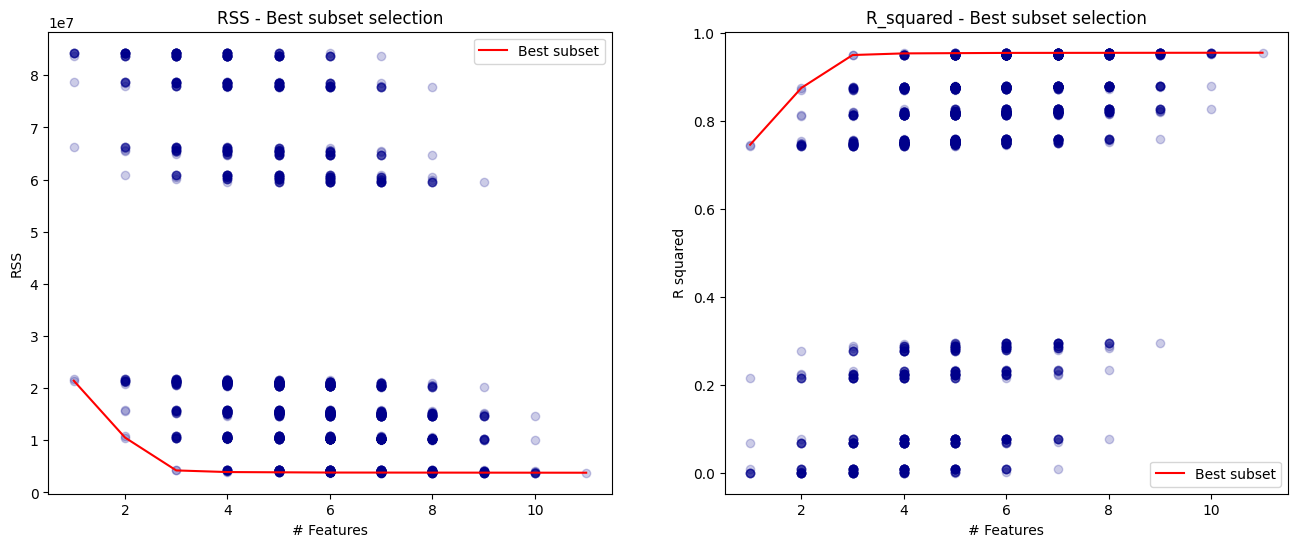

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].scatter(df['num_features'], df['RSS'], alpha=0.2, color='darkblue')
axes[0].plot(df['num_features'], df['min_RSS'], color='r', label='Best subset')

axes[0].set_xlabel('# Features')
axes[0].set_ylabel('RSS')
axes[0].set_title('RSS - Best subset selection')
axes[0].legend()


axes[1].scatter(df['num_features'], df['R_squared'], alpha=0.2, color='darkblue')
axes[1].plot(df['num_features'], df['max_R_squared'], color='r', label='Best subset')

axes[1].set_xlabel('# Features')
axes[1].set_ylabel('R squared')
axes[1].set_title('R_squared - Best subset selection')
axes[1].legend()

plt.show()

<a id='forward'></a>
### 5.9. Forward stepwise selection
For computational reasons, the best subset cannot be applied for any large n due to the 2^n complexity.

Forward Stepwise begins with a model containing no predictors, and then adds predictors to the model, one at the time.

At each step, the variable that gives the greatest additional improvement to the fit is added to the model.

### Algorithm
Let M0 denote the null model which contains no predictors

- For k=1, 2, ... , n−1
    - Consider all n−k models that augment the predictors in Mk with one additional predictor
    - Choose the 'best' among these n−k models, and call it Mk+1
- Select the single best model among M0,M1,...,Mn using cross validated predicton error, Cp, BIC, adjusted R2 or any other method.

In [ ]:
# Initialization variables
Y = credit['Balance']
X = credit.drop(columns=['Balance'])

remaining_features = list(X.columns)
features = []
RSS_dict, R_squared_dict, features_dict = {}, {}, {}

for k in tnrange(1, len(X.columns) + 1):

    best_RSS = np.inf
    for feature in remaining_features:
        RSS, R_squared = fit_linear_reg(X[features + [feature]], Y)
        if RSS < best_RSS:
            best_RSS = RSS
            best_R_squared = R_squared
            best_feature = feature

    # Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    assert len(features) == k

    # Saving values for plotting
    RSS_dict[k] = best_RSS
    R_squared_dict[k] = best_R_squared
    features_dict[k] = features.copy()

forward_results = RSS_dict, R_squared_dict, features_dict

  0%|          | 0/11 [00:00<?, ?it/s]

### 5.10. Displaying results of the first 4 steps

In [ ]:
print('Forward stepwise subset selection')
print('Number of features |', '   RSS    |', 'Features')

for k in range(1, 5):
    print(f'{k:^19}|{round(RSS_dict[k]):^11}| {features_dict[k]}')

Forward stepwise subset selection
Number of features |    RSS    | Features
         1         | 21435122  | ['Rating']
         2         | 10532541  | ['Rating', 'Income']
         3         |  4227219  | ['Rating', 'Income', 'Student_Yes']
         4         |  4032502  | ['Rating', 'Income', 'Student_Yes', 'Limit']


### 5.11. Exercise - Backward stepwise selection
For computational reasons, the best subset cannot be applied for any large n due to the 2^n complexity.
Backward Stepwise begins with a model containing all predictors, and then removes predictors to the model, one at the time.
At each step, the variable that gives the smallest additional improvement to the fit is removed from the model.

1. Implement Backward stepwise selection (Refer to Section 5.9.)
2. Display the results of the first 4 steps (Refer to Section 5.10.)

__This will be covered in the HW 1.__

## 6. Ridge Regression

### 6.1. Load dataset

In [ ]:
# In R, I exported the dataset from package 'ISLR' to a csv file.
hitters = pd.read_csv(f'{BASE_DIR}/Data/Hitters.csv', index_col=0).dropna()
hitters.index.name = 'Player'
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 

In [ ]:
hitters.head()

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
Player                                                                          
-Alan Ashby          315    81      7    24   38     39     14    3449    835   
-Alvin Davis         479   130     18    66   72     76      3    1624    457   
-Andre Dawson        496   141     20    65   78     37     11    5628   1575   
-Andres Galarraga    321    87     10    39   42     30      2     396    101   
-Alfredo Griffin     594   169      4    74   51     35     11    4408   1133   

                   CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  \
Player                                                                    
-Alan Ashby            69    321   414     375      N        W      632   
-Alvin Davis           63    224   266     263      A        W      880   
-Andre Dawson         225    828   838     354      N        E      200   
-Andres Galarraga      12     48    46      33      N        E      805   
-Alfredo Griffin       19    501   336     194      A        W      282   

                   Assists  Errors  Salary NewLeague  
Player                                                
-Alan Ashby             43      10   475.0         N  
-Alvin Davis            82      14   480.0         A  
-Andre Dawson           11       3   500.0         N  
-Andres Galarraga       40       4    91.5         N  
-Alfredo Griffin       421      25   750.0         A

In [ ]:
hitters = pd.get_dummies(hitters, columns=['League', 'Division', 'NewLeague'], drop_first=True)
hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    int64  
 1   Hits         263 non-null    int64  
 2   HmRun        263 non-null    int64  
 3   Runs         263 non-null    int64  
 4   RBI          263 non-null    int64  
 5   Walks        263 non-null    int64  
 6   Years        263 non-null    int64  
 7   CAtBat       263 non-null    int64  
 8   CHits        263 non-null    int64  
 9   CHmRun       263 non-null    int64  
 10  CRuns        263 non-null    int64  
 11  CRBI         263 non-null    int64  
 12  CWalks       263 non-null    int64  
 13  PutOuts      263 non-null    int64  
 14  Assists      263 non-null    int64  
 15  Errors       263 non-null    int64  
 16  Salary       263 non-null    float64
 17  League_N     263 non-null    bool   
 18  Division_W   263 non-null    bool 

In [ ]:
y = hitters['Salary']

X = hitters.drop(columns=['Salary'])
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   AtBat        263 non-null    int64
 1   Hits         263 non-null    int64
 2   HmRun        263 non-null    int64
 3   Runs         263 non-null    int64
 4   RBI          263 non-null    int64
 5   Walks        263 non-null    int64
 6   Years        263 non-null    int64
 7   CAtBat       263 non-null    int64
 8   CHits        263 non-null    int64
 9   CHmRun       263 non-null    int64
 10  CRuns        263 non-null    int64
 11  CRBI         263 non-null    int64
 12  CWalks       263 non-null    int64
 13  PutOuts      263 non-null    int64
 14  Assists      263 non-null    int64
 15  Errors       263 non-null    int64
 16  League_N     263 non-null    bool 
 17  Division_W   263 non-null    bool 
 18  NewLeague_N  263 non-null    bool 
dtypes: bool(3), int64(16)
memory usage

In [ ]:
X.head(5)

AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  \
Player                                                                          
-Alan Ashby          315    81      7    24   38     39     14    3449    835   
-Alvin Davis         479   130     18    66   72     76      3    1624    457   
-Andre Dawson        496   141     20    65   78     37     11    5628   1575   
-Andres Galarraga    321    87     10    39   42     30      2     396    101   
-Alfredo Griffin     594   169      4    74   51     35     11    4408   1133   

                   CHmRun  CRuns  CRBI  CWalks  PutOuts  Assists  Errors  \
Player                                                                     
-Alan Ashby            69    321   414     375      632       43      10   
-Alvin Davis           63    224   266     263      880       82      14   
-Andre Dawson         225    828   838     354      200       11       3   
-Andres Galarraga      12     48    46      33      805       40       4   
-Alfredo Griffin       19    501   336     194      282      421      25   

                   League_N  Division_W  NewLeague_N  
Player                                                
-Alan Ashby            True        True         True  
-Alvin Davis          False        True        False  
-Andre Dawson          True       False         True  
-Andres Galarraga      True       False         True  
-Alfredo Griffin      False        True        False

#### I executed the R code and downloaded the exact same training/test sets used in the book.

In [ ]:
X_train = pd.read_csv(f'{BASE_DIR}/Data/Hitters_X_train.csv', index_col=0)
Y_train = pd.read_csv(f'{BASE_DIR}/Data/Hitters_y_train.csv', index_col=0)
X_test = pd.read_csv(f'{BASE_DIR}/Data/Hitters_X_test.csv', index_col=0)
Y_test = pd.read_csv(f'{BASE_DIR}/Data/Hitters_y_test.csv', index_col=0)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(131, 19) (131, 1) (132, 19) (132, 1)


### 6.2. Ridge Regression in scikit-learn

The __glmnet__ algorithms in R optimize the objective function using cyclical coordinate descent, while scikit-learn Ridge regression uses linear least squares with L2 regularization. They are rather different implementations, but the general principles are the same.

The __glmnet() function in R__ optimizes:
### $$ \frac{1}{N}|| X\beta-y||^2_2+\lambda\bigg(\frac{1}{2}(1−\alpha)||\beta||^2_2 \ +\ \alpha||\beta||_1\bigg) $$
(See R documentation and https://cran.r-project.org/web/packages/glmnet/vignettes/glmnet_beta.pdf)<BR>
The function supports L1 and L2 regularization. For just Ridge regression we need to use $\alpha = 0 $. This reduces the above cost function to
### $$ \frac{1}{N}|| X\beta-y||^2_2+\frac{1}{2}\lambda ||\beta||^2_2 $$
The __sklearn Ridge()__ function optimizes:
### $$ ||X\beta - y||^2_2 + \alpha ||\beta||^2_2 $$
which is equivalent to optimizing
### $$ \frac{1}{N}||X\beta - y||^2_2 + \frac{\alpha}{N} ||\beta||^2_2 $$

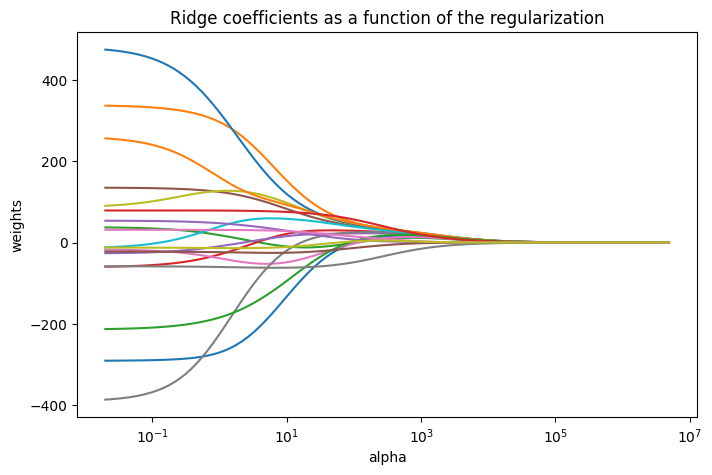

In [ ]:
alphas = 5**np.linspace(-2, 10, 100) * 0.5

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(scale(X), y)
    coefs.append(ridge.coef_)


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, coefs)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Ridge coefficients as a function of the regularization')
plt.show()

The above plot shows that the Ridge coefficients get larger when we decrease alpha.

#### 6.2.1. Alpha = 4

In [ ]:
scaler = StandardScaler().fit(X_train)

In [ ]:
ridge = Ridge(alpha=4)
ridge.fit(scaler.transform(X_train), Y_train)
pred = ridge.predict(scaler.transform(X_test))
mean_squared_error(Y_test, pred)

97383.68965102121

In [ ]:
pd.Series(ridge.coef_.reshape(-1), index=X.columns)

AtBat         -161.784058
Hits           118.911404
HmRun           52.645719
Runs           -43.295947
RBI             37.339573
Walks          138.214992
Years         -106.916784
CAtBat         -21.080864
CHits          115.933862
CHmRun         -17.949420
CRuns          239.723217
CRBI           -17.945273
CWalks         -59.754770
PutOuts         21.752383
Assists        -68.676906
Errors          89.610291
League_N        31.048268
Division_W     -13.553466
NewLeague_N      4.350305
dtype: float64

#### 6.2.2. Alpha = $10^{10}$  (Alpha graph & find optimal alpha)
This big penalty shrinks the coefficients to a very large degree and makes the model more biased, resulting in a higher MSE.

In [ ]:
ridge = Ridge(alpha=10**10)
ridge.fit(scale(X_train), Y_train)
pred = ridge.predict(scale(X_test))
mean_squared_error(Y_test, pred)

193253.09741651407

In [ ]:
pd.Series(ridge.coef_.reshape(-1), index=X.columns)

AtBat          2.291553e-06
Hits           2.428111e-06
HmRun          2.051677e-06
Runs           2.372252e-06
RBI            2.538921e-06
Walks          2.974270e-06
Years          1.572334e-06
CAtBat         2.507043e-06
CHits          2.666936e-06
CHmRun         2.280416e-06
CRuns          2.839982e-06
CRBI           2.526355e-06
CWalks         2.544939e-06
PutOuts        4.880225e-07
Assists       -1.149268e-06
Errors         2.067779e-06
League_N       5.324293e-07
Division_W     5.051366e-07
NewLeague_N    5.291999e-07
dtype: float64

#### 6.2.3. Training mse with different alpha value

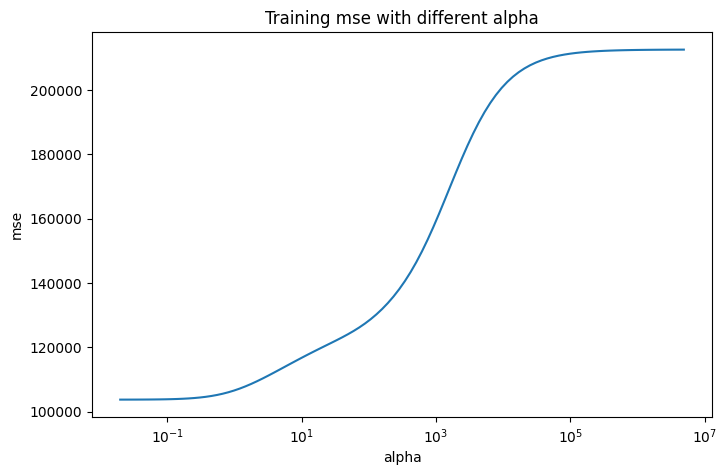

In [ ]:
mses = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(scaler.transform(X_train), Y_train)
    pred = ridge.predict(scaler.transform(X_train))
    mses.append(mean_squared_error(Y_train, pred))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('mse')
ax.set_title('Training mse with different alpha')
plt.show()

#### 6.2.4. Training mse with different alpha value (Cross validation)

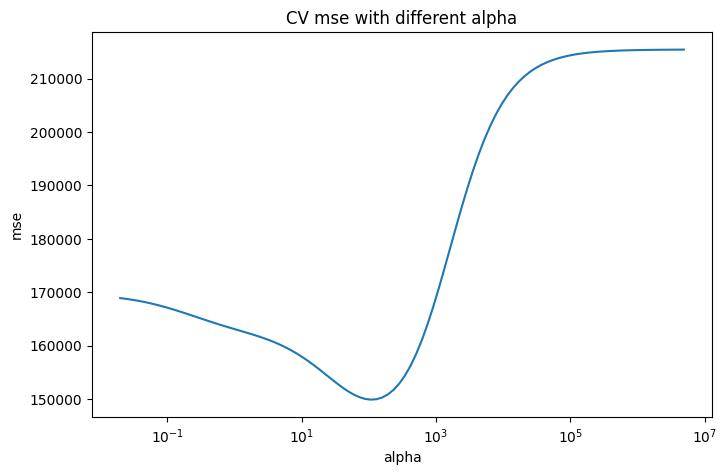

In [ ]:
mses = []
for a in alphas:
    ridge = Ridge(alpha=a)
    cv_mses = -cross_val_score(ridge,
                              scale(X_train),
                              Y_train,
                              cv=10,
                              scoring='neg_mean_squared_error')
    mses.append(np.mean(cv_mses))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('mse')
ax.set_title('CV mse with different alpha')
plt.show()

#### 6.2.5. Test mse with different alpha value

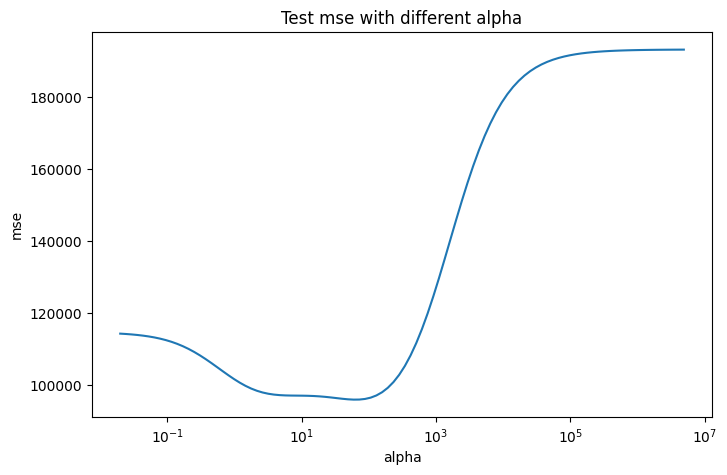

In [ ]:
mses = []
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(scaler.transform(X_train), Y_train)
    pred = ridge.predict(scaler.transform(X_test))
    mses.append(mean_squared_error(Y_test, pred))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('mse')
ax.set_title('Test mse with different alpha')
plt.show()

#### 6.2.6. Compute the regularization path using RidgeCV
Ridge regression with built-in cross-validation.

Default cross validation method is "Generalized Cross-Validation" (efficient Leave-One-Out).

In [ ]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), Y_train)

RidgeCV(alphas=array([2.00000000e-02, 2.43082465e-02, 2.95445425e-02, 3.59088012e-02,
       4.36439996e-02, 5.30454551e-02, 6.44721001e-02, 7.83601852e-02,
       9.52399351e-02, 1.15755791e-01, 1.40691016e-01, 1.70997595e-01,
       2.07832585e-01, 2.52602285e-01, 3.07015931e-01, 3.73150948e-01,
       4.53532262e-01, 5.51228702e-01, 6.69970160e-01, 8.14289991e-01,
       9.89698093e-01, 1.20289126e+0...
       5.49574280e+04, 6.67959354e+04, 8.11846033e+04, 9.86727677e+04,
       1.19928098e+05, 1.45762089e+05, 1.77161040e+05, 2.15323712e+05,
       2.61707094e+05, 3.18082028e+05, 3.86600818e+05, 4.69879399e+05,
       5.71097214e+05, 6.94118595e+05, 8.43640297e+05, 1.02537082e+06,
       1.24624833e+06, 1.51470558e+06, 1.84099184e+06, 2.23756418e+06,
       2.71956308e+06, 3.30539050e+06, 4.01741235e+06, 4.88281250e+06]),
        scoring='neg_mean_squared_error')

In [ ]:
# Optimal alpha that RidgeCV found
ridgecv.alpha_

106.87349666729367

In [ ]:
ridge = Ridge(alpha=ridgecv.alpha_)
ridge.fit(scale(X_train), Y_train)
mean_squared_error(Y_test, ridge.predict(scale(X_test)))
# Compare this mse value with an above graph (MSE with different alpha)

97171.90036529173

In [ ]:
pd.Series(ridge.coef_.reshape(-1), index=X.columns)

AtBat           6.527403
Hits           22.754323
HmRun          19.213875
Runs           20.029787
RBI            21.072806
Walks          57.407651
Years          -5.790283
CAtBat         20.637323
CHits          29.977244
CHmRun         14.050638
CRuns          37.018236
CRBI           20.284659
CWalks         24.526594
PutOuts        16.522197
Assists       -45.652512
Errors         56.322520
League_N        6.000427
Division_W     -0.571164
NewLeague_N    11.210351
dtype: float64

## 7. The Lasso

### 7.1. Scikit-learn

For both __glmnet__ in R and sklearn __Lasso()__ function the standard L1 penalty is:
### $$ \lambda |\beta|_1 $$

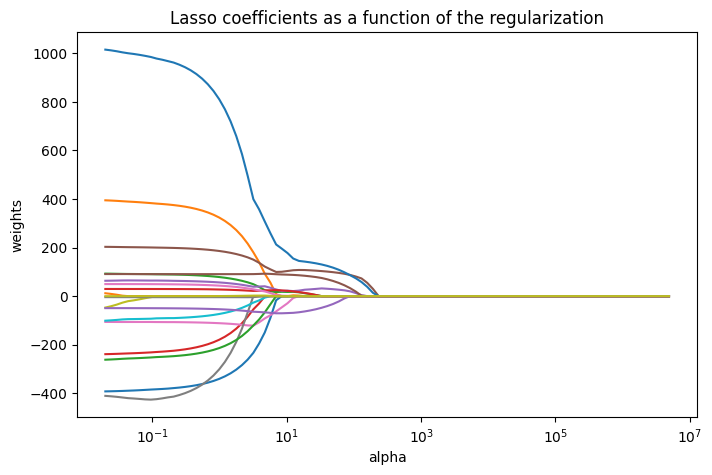

In [ ]:
alphas = 5**np.linspace(-2, 10, 100) * 0.5

coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(scale(X_train), Y_train)
    coefs.append(lasso.coef_)


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, coefs)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Lasso coefficients as a function of the regularization')
plt.show()

#### 7.1.1. Training mse with different alpha value

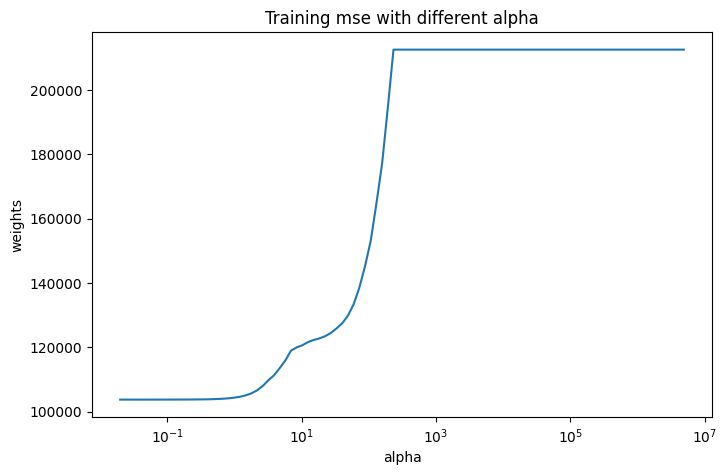

In [ ]:
mses = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(scale(X_train), Y_train)
    mses.append(mean_squared_error(Y_train, lasso.predict(scale(X_train))))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Training mse with different alpha')
plt.show()

#### 7.1.2. Training mse with different alpha value (Cross validataion)

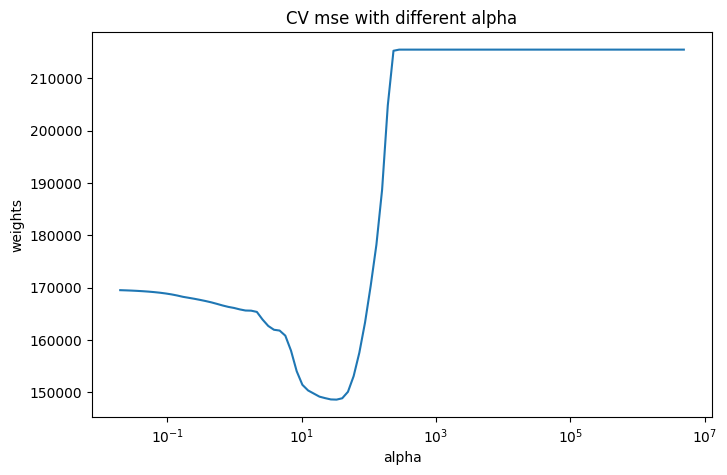

In [ ]:
mses = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    cv_mses = -cross_val_score(lasso,
                               scale(X_train),
                               Y_train,
                               cv=10,
                               scoring='neg_mean_squared_error')
    mses.append(np.mean(cv_mses))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('CV mse with different alpha')
plt.show()

####  7.1.3. Test mse with different alpha value

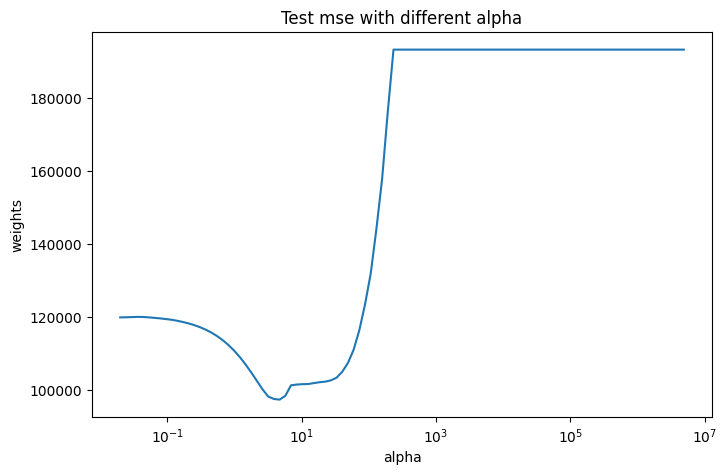

In [ ]:
mses = []
for a in alphas:
    lasso = Lasso(alpha=a, max_iter=10000)
    lasso.fit(scale(X_train), Y_train)
    mses.append(mean_squared_error(Y_test, lasso.predict(scale(X_test))))


fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(alphas, mses)

ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('weights')
ax.set_title('Test mse with different alpha')
plt.show()

####  7.1.4. Compute the regularization path using LassoCV
Lasso regression with built-in cross-validation.

Alphas are set automatically

In [ ]:
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000)
lassocv.fit(scale(X_train), Y_train)

LassoCV(cv=10, max_iter=10000)

In [ ]:
lassocv.alpha_

30.01382256446427

In [ ]:
lasso = Lasso(alpha=lassocv.alpha_, max_iter=10000)
lasso.fit(scale(X_train), Y_train)
mean_squared_error(Y_test, lasso.predict(scale(X_test)))

102924.90954696966

In [ ]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X_train.columns)

AtBat           0.000000
Hits            0.000000
HmRun           2.154219
Runs            0.000000
RBI            30.835560
Walks         104.071528
Years          -0.000000
CAtBat          0.000000
CHits           0.000000
CHmRun          0.000000
CRuns         132.858095
CRBI            0.000000
CWalks          0.000000
LeagueN         1.896185
DivisionW     -51.058752
PutOuts        76.779641
Assists         0.000000
Errors          0.000000
NewLeagueN      0.000000
dtype: float64